<a href="https://colab.research.google.com/github/SwastikGorai/asl_Classifier/blob/main/asl_rev01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train a model to recognise ASL with ≈ 93% accuracy

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### Install the necessary modules

In [ ]:
!pip install tensorflow-gpu==2.4.0
!pip install kaggle
!pip install opencv-python
!pip install matplotlib

### Import the necessary modules ###

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os

### Download and load the dataset from Kaggle

In [ ]:
# Replace "YOUR_API_KEY" with your actual API key from Kaggle
# If it throws error, run cell again
!echo '{"username":"USERNAME","key":"YOUR_API_KEY"}' > /root/.kaggle/kaggle.json

# Download the ASL dataset
!kaggle datasets download -d grassknoted/asl-alphabet

# Unzip the downloaded dataset
!unzip asl-alphabet.zip


In [ ]:
# Load the data
Xl = []
yl = []
ls = []

# Load the images and labels from the dataset
for directory in os.listdir('asl_alphabet_train'):
  i = 0
  for filename in os.listdir(f'asl_alphabet_train/{directory}'):
    print(f"Obtaining images: {filename}")
    ls.append(filename)
    for ff in os.listdir(f'asl_alphabet_train/{directory}/{filename}'):
      image = cv2.imread(f'asl_alphabet_train/{directory}/{filename}/{ff}')
      if image is not None:
        image = cv2.resize(image, (64, 64))
        Xl.append(image)
        yl.append(i)
    i+=1

### Check the loaded data


In [ ]:
# Display the CORRESPONDING labels for x1
ls

In [ ]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

In [ ]:
train_dir = '/content/asl_alphabet_train/asl_alphabet_train'
test_dir = '/content/asl_alphabet_test/asl_alphabet_test'

<Figure size 432x288 with 0 Axes>

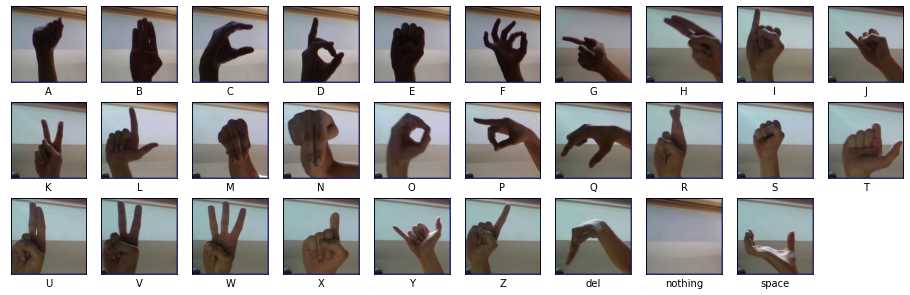

In [ ]:
def plot_sample_images():
    figure = plt.figure()
    plt.figure(figsize=(16,5))

    for i in range (0,29):
        plt.subplot(3,10,i+1)
        plt.xticks([])
        plt.yticks([])
        path = train_dir + "/{0}/{0}1.jpg".format(classes[i])
        img = plt.imread(path)
        plt.imshow(img)
        plt.xlabel(classes[i])
        
plot_sample_images()

In [ ]:
print(len(Xl), len(yl))

87000 87000


### Preprocess the data

In [ ]:
# Convert the data to NumPy arrays
X = np.array(Xl)
X_normalised = X.astype('float32')/255.0
OneHot_Encoded_y = utils.to_categorical(yl)

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_normalised, OneHot_Encoded_y, test_size=0.2, random_state=42)

In [ ]:
print("Training data:", X_train.shape)
print("Test data:", X_val.shape)

Training data: (69600, 64, 64, 3)
Test data: (17400, 64, 64, 3)


In [ ]:
# To check Nullity of variables
print(X_train, X_val, y_train, y_val)

### Define, compile and fit the model

In [ ]:
# Define the model
model = tf.keras.models.Sequential()

# Add the first convolutional layer
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Add the second convolutional layer
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Add the third convolutional layer
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Add a flattening layer
model.add(tf.keras.layers.Flatten())

# Add the first fully connected layer
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

# Add the second fully connected layer
model.add(tf.keras.layers.Dense(29, activation='softmax'))


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

### Train and evaluate the model

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

In [ ]:
# Store the various metrics of model.fit()
history = model.fit(X_train, y_train, batch_size=32, epochs=15, validation_split=0.2, shuffle = True, verbose=1)

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')


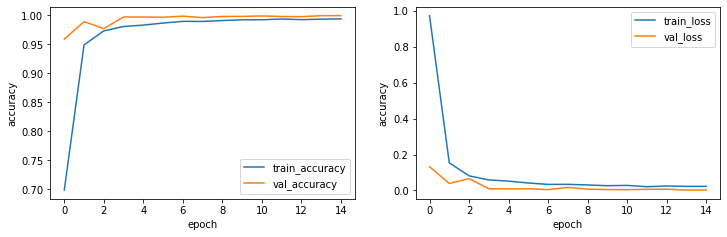

In [ ]:
def plot_results(model):
  plt.figure(figsize=(12, 12))
  plt.subplot(3, 2, 1)
  plt.plot(history.history['accuracy'], label = 'train_accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.subplot(3, 2, 2)
  plt.plot(history.history['loss'], label = 'train_loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()
plot_results(model)

### Save the model

In [ ]:
# Save the model
model.save('model.h5')

In [ ]:
# Save the model in the SavedModel format
tf.saved_model.save(model, 'saved_model')

In [ ]:
# Save the model in .tflite format
!tflite_convert \
  --saved_model_dir=saved_model \
  --output_file=model.tflite

